In [47]:
import torch
import torchvision
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
from keras.datasets import mnist

print(torch.__version__)

1.13.0


In [92]:
config = EasyDict({
    'INPUT_DIM' : 784,
    'HIDDEN_DIM': 1024,
    'Z_DIM': 2,
    'LR': 1e-3,
    'BATCH_SIZE':2048,
    'EPOCHS':30,
    'DEVICE': 'cuda' if torch.cuda.is_available else 'cpu'
})

print(config.DEVICE)

cuda


In [101]:

'''
References
- https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/VAE/lightning_vae/model.py
'''

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        
        self.relu = nn.ReLU()

        # Encoder
        self.image_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_hidden_enc = nn.Linear(hidden_dim, hidden_dim) # Layer 1개만 학습하면 생성되는 이미지의 품질이 좋지 않았음. 
        self.hidden_to_mu = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_hidden_dec = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_to_image = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = self.relu(self.image_to_hidden(x))
        h = self.relu(self.hidden_to_hidden_enc(h))
        mu = self.hidden_to_mu(h)
        log_var = self.hidden_to_sigma(h)
        return mu, log_var # log variance로 학습하는 경우도 있음. -> Training stability
        
    def decode(self, z):
        h = self.relu(self.z_to_hidden(z))
        h = self.relu(self.hidden_to_hidden_dec(h))
        x_hat = torch.sigmoid(self.hidden_to_image(h)) # Why sigmoid? -> For reconstruction error. Normalized Our Data to 0~1. 
        return x_hat
    
    def reparametrization(self, mu, log_var):
        epsilon = torch.randn_like(log_var) # epsilon ~ N(0,I)
        sigma = torch.exp(0.5 * log_var)
        z_new = mu + sigma * epsilon.cuda() # 논문의 (10)식 - where ~ 부분 그대로 구현
        return z_new
    
    def forward(self, x):
        mu, log_var = self.encode(x) # x -> q_(phi)(z|x) -> mu, sigma
        z = self.reparametrization(mu, log_var) # (mu, sigma) -> z
        x_reconstructed = self.decode(z) # z -> p_(theta)(x|z) -> x'
        return x_reconstructed, mu, log_var


In [102]:
train_dataset = MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = MNIST(root="dataset/", transform=transforms.ToTensor(), train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset=test_dataset, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=False)

model = VariationalAutoEncoder(input_dim = config.INPUT_DIM,
                             hidden_dim = config.HIDDEN_DIM,
                             z_dim = config.Z_DIM)
model.to(config.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=config.LR)

In [103]:
for epoch in range(config.EPOCHS):
    loop = tqdm(enumerate(train_loader))
    total_loss = 0
    for i, (x, _) in loop:
        x = x.to(config.DEVICE).view(x.shape[0],config.INPUT_DIM) # (batch_size, 1, 28, 28) -> (batch, 784)
        x_reconstructed, mu, log_var = model(x)
        
        # Reconstruction error
        reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum') # CE
#         reconstruction_loss = F.mse_loss(x_reconstructed, x,reduction='sum') # MSE

        # Regularization term (KL divergence)
        # [B, z_dim] -> sum(dim=1) -> [B] -> mean(dim=0) -> loss val
        # kld_loss = -torch.mean(0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2, dim=1), dim=0) # 논문의 10번 식 앞부분 그대로 
        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()) # 논문의 10번 식 앞부분 그대로 

        loss = reconstruction_loss + kld_loss
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
    print("Epoch: {}/{}".format(epoch + 1, config.EPOCHS), "\tAverage Loss: {:.6f}".format(total_loss / (i*config.BATCH_SIZE)))

      

30it [00:05,  5.30it/s, loss=1.23e+5]

Epoch: 1/30 	Average Loss: 247.257232



30it [00:05,  5.26it/s, loss=1.11e+5]

Epoch: 2/30 	Average Loss: 195.532370



30it [00:05,  5.10it/s, loss=1.05e+5]

Epoch: 3/30 	Average Loss: 180.201628



30it [00:05,  5.34it/s, loss=1.04e+5]

Epoch: 4/30 	Average Loss: 173.299623



30it [00:06,  4.80it/s, loss=1.01e+5]

Epoch: 5/30 	Average Loss: 169.062496



30it [00:05,  5.22it/s, loss=9.95e+4]

Epoch: 7/30 	Average Loss: 163.892594



30it [00:05,  5.11it/s, loss=9.58e+4]

Epoch: 8/30 	Average Loss: 161.692951



30it [00:05,  5.43it/s, loss=9.49e+4]

Epoch: 9/30 	Average Loss: 159.440210



30it [00:06,  4.62it/s, loss=9.52e+4]

Epoch: 10/30 	Average Loss: 157.361626



30it [00:05,  5.44it/s, loss=9.34e+4]

Epoch: 11/30 	Average Loss: 155.884226



30it [00:05,  5.13it/s, loss=9.13e+4]

Epoch: 12/30 	Average Loss: 154.744779



30it [00:05,  5.35it/s, loss=8.99e+4]

Epoch: 13/30 	Average Loss: 153.389497



30it [00:05,  5.25it/s, loss=8.9e+4] 

Epoch: 14/30 	Average Loss: 152.439832



30it [00:06,  4.85it/s, loss=8.92e+4]

Epoch: 15/30 	Average Loss: 151.778295



30it [00:05,  5.48it/s, loss=8.96e+4]

Epoch: 16/30 	Average Loss: 150.554474



30it [00:05,  5.28it/s, loss=8.94e+4]

Epoch: 17/30 	Average Loss: 149.760733



30it [00:05,  5.43it/s, loss=9.03e+4]

Epoch: 18/30 	Average Loss: 148.992616



30it [00:05,  5.30it/s, loss=9.02e+4]

Epoch: 19/30 	Average Loss: 148.453001



30it [00:05,  5.42it/s, loss=9.06e+4]

Epoch: 20/30 	Average Loss: 147.858309



30it [00:06,  4.84it/s, loss=8.58e+4]

Epoch: 21/30 	Average Loss: 147.266028



30it [00:05,  5.42it/s, loss=8.97e+4]

Epoch: 22/30 	Average Loss: 146.568449



30it [00:05,  5.27it/s, loss=8.78e+4]

Epoch: 23/30 	Average Loss: 146.888859



30it [00:05,  5.44it/s, loss=8.72e+4]

Epoch: 24/30 	Average Loss: 146.106024



30it [00:05,  5.27it/s, loss=8.65e+4]

Epoch: 25/30 	Average Loss: 145.463794



30it [00:06,  4.92it/s, loss=8.89e+4]

Epoch: 26/30 	Average Loss: 144.969483



30it [00:05,  5.28it/s, loss=8.53e+4]

Epoch: 27/30 	Average Loss: 144.555564



30it [00:05,  5.36it/s, loss=8.59e+4]

Epoch: 28/30 	Average Loss: 144.293701



30it [00:05,  5.27it/s, loss=8.56e+4]

Epoch: 29/30 	Average Loss: 143.895490



30it [00:05,  5.33it/s, loss=8.69e+4]

Epoch: 30/30 	Average Loss: 143.687614


# Image Generation

In [104]:
# Generate Images

def reparametrization(mu, log_var):
    epsilon = torch.randn_like(log_var) # epsilon ~ N(0,I)
    sigma = torch.exp(0.5 * log_var)
    z_new = mu + sigma * epsilon.cuda() # 논문의 (10)식 - where 부분 그대로 구현
    return z_new


with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader): ## Test Images
        x = x.view(config.BATCH_SIZE, config.INPUT_DIM)
        x = x.to(config.DEVICE)

        phi = model.encode(x)
        mu, log_var = phi[0], phi[1]
        z_new = reparametrization(mu, log_var)
        x_generated = model.decode(z_new)

        break

Text(0.5, 1.0, 'Generated Samples')

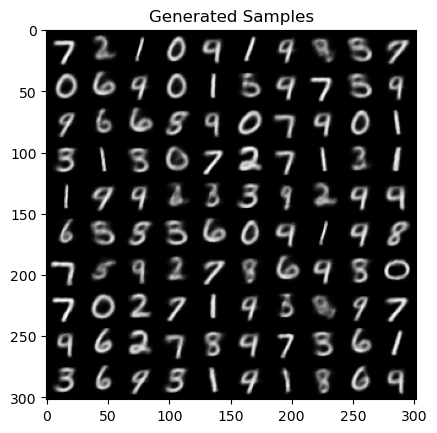

In [105]:
plt.imshow(torchvision.utils.make_grid(x_generated[:100].view(-1,1,28,28).detach().cpu(), nrow=10).permute(1,2,0))
plt.title('Generated Samples')

# Latent space vis

In [106]:
(_, _), (X_test, y_test) = mnist.load_data()
X_test = X_test/255.0

In [170]:
# Reference: https://savadikarc.github.io/post/2020/01/30/vae_vis/
def plot_latent(X, y, enc, config, samples_per_class=10):

    """
    Plot the transformed samples from the test set
    """
    latent_vectors = []
    fig = plt.figure(figsize=(10, 10))

    for digit in range(10):

        # Draw 10 random samples
        _X = X[y == digit]
        _y = y[y == digit]
        indices = np.random.permutation(np.arange(_X.shape[0]))
        _X = _X[indices[:samples_per_class]]

        X_sample = torch.from_numpy(_X).float().to(config.DEVICE)
        X_sample = X_sample.view(X_sample.shape[0],config.INPUT_DIM)
        mu, log_var = enc(X_sample)
        z = (mu + torch.randn_like(mu) * torch.exp(log_var / 2.)).detach().cpu().numpy() # reparametrization
        latent_vectors.append(z)
        plt.scatter(z[:, 0], z[:, 1], c=None, alpha=0.7)
    plt.legend([_ for _ in range(10)])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()
    
    return latent_vectors, fig


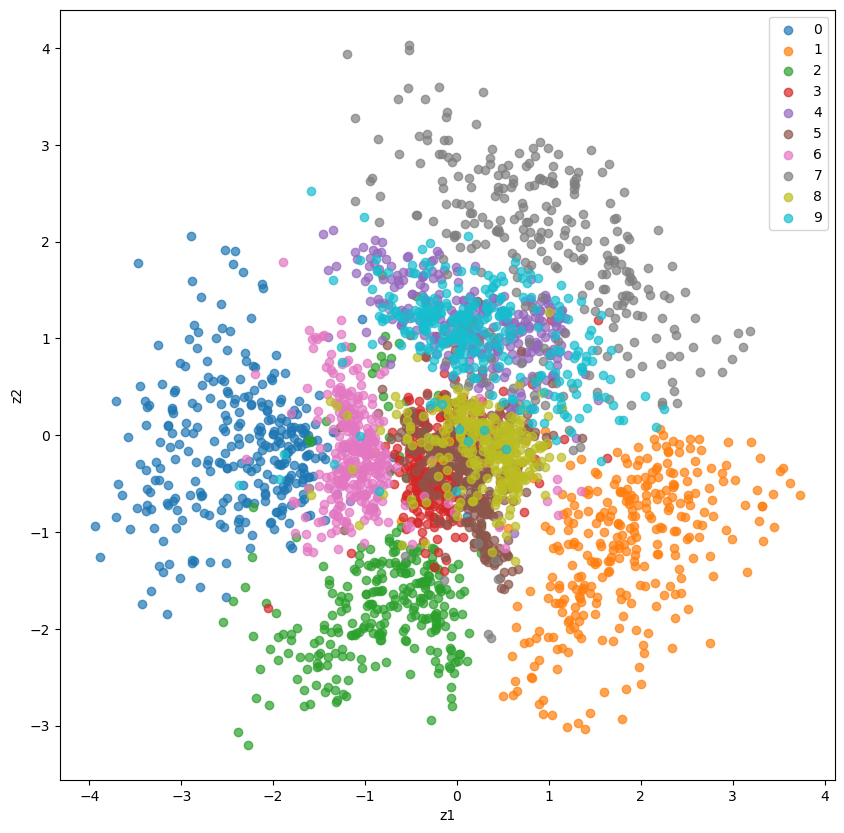

In [183]:
latent_vectors, figure = plot_latent(X_test, y_test, model.encode, config, samples_per_class=300)

In [184]:
digit_num = 1
mean_z = (latent_vectors[digit_num][0]+latent_vectors[digit_num][1])/2 # 임이의 두 벡

with torch.no_grad():
    x_generated = model.decode(torch.tensor(mean_z).cuda())

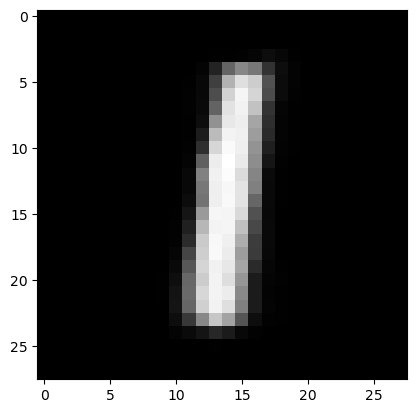

In [185]:
plt.imshow(x_generated.view(28,28).cpu().numpy(), cmap='gray')

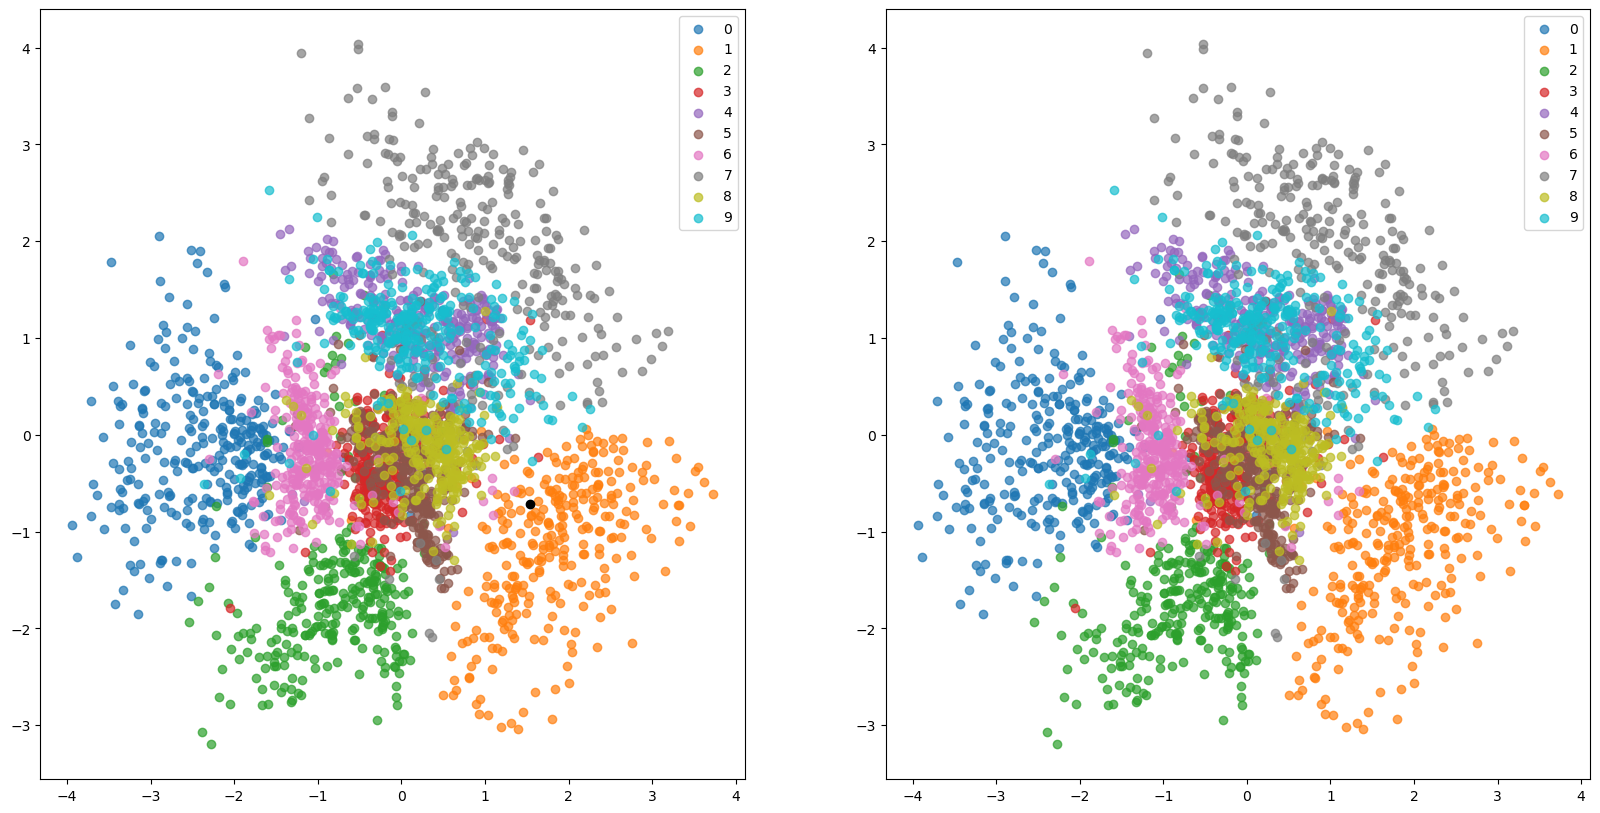

In [214]:
fig , axes = plt.subplots(1,2)
fig.set_size_inches(20, 10)

for z in latent_vectors:
    axes[0].scatter(z[:, 0], z[:, 1], c=None, alpha=0.7)
    axes[1].scatter(z[:, 0], z[:, 1], c=None, alpha=0.7)
axes[0].legend([_ for _ in range(10)])
axes[1].legend([_ for _ in range(10)])

axes[0].scatter(mean_z[0], mean_z[1], c='black', alpha=1)